In [1]:
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import torch
import torch.nn.functional as F
from dotenv import load_dotenv
import os

In [2]:
from huggingface_hub import HfFolder, whoami
load_dotenv()
hf_token = os.getenv('HF_TOKEN')
HfFolder.save_token(hf_token)
user = whoami()
print(f"logged in as {user["name"]}")

logged in as M00nl8tshad0w


In [3]:
def load_model(model_name, local_dir="./models/llama3_70b"):
    if os.path.exists(local_dir):
        print(f"Loading model from local directory: {local_dir}")
        tokenizer = AutoTokenizer.from_pretrained(local_dir)
        model = AutoModelForCausalLM.from_pretrained(local_dir, device_map="auto", torch_dtype="auto")
    else:
        print(f"Local directory not found. Downloading model '{model_name}' from Hugging Face Hub...")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype="auto")

        os.makedirs(local_dir, exist_ok=True)
        tokenizer.save_pretrained(local_dir)
        model.save_pretrained(local_dir)
        print(f"Model downloaded and saved locally to: {local_dir}")

    return tokenizer, model

In [4]:
tokenizer, model = load_model(model_name="meta-llama/Llama-3.3-70B-Instruct",
                              local_dir="/home/max/Studium/Leipzig/Semster6/Math_and_ML/hf_models/llama3_70b/")

Loading model from local directory: /home/max/Studium/Leipzig/Semster6/Math_and_ML/hf_models/llama3_70b/


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the disk and cpu.


In [5]:
def load_hf_dataset(dataset_name, subset="default", local_dir="~/hf_datasets/OpenR1_Math_220k/"):
    local_dir = os.path.expanduser(local_dir)
    os.makedirs(local_dir, exist_ok=True)
    return load_dataset(dataset_name, subset, cache_dir=local_dir)

In [6]:
math_dataset = load_hf_dataset(dataset_name="open-r1/OpenR1-Math-220k",
                               local_dir="/home/max/Studium/Leipzig/Semster6/Math_and_ML/hf_datasets/open-r1/OpenR1-Math-220k")

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

In [9]:
question = math_dataset["train"]["problem"][0]
print(question)
inputs = tokenizer(question, return_tensors="pt")
inputs = {k: v.to(model.device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)

## Task B-1.3.

A ship traveling along a river has covered $24 \mathrm{~km}$ upstream and $28 \mathrm{~km}$ downstream. For this journey, it took half an hour less than for traveling $30 \mathrm{~km}$ upstream and $21 \mathrm{~km}$ downstream, or half an hour more than for traveling $15 \mathrm{~km}$ upstream and $42 \mathrm{~km}$ downstream, assuming that both the ship and the river move uniformly.

Determine the speed of the ship in still water and the speed of the river.


In [11]:
logits = outputs.logits
print("Logits shape:", logits.shape)

Logits shape: torch.Size([1, 126, 128256])


In [14]:
probs = torch.nn.functional.softmax(logits, dim=-1)
predicted_token_id = torch.argmax(logits[:, -1, :], dim=-1)
predicted_token = tokenizer.decode(predicted_token_id)
print("Predicted next token:", predicted_token)

Predicted next token:  Let


In [19]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM

# Step 0: Load model + dataset
tokenizer, model = load_model(
    model_name="meta-llama/Llama-3.3-70B-Instruct",
    local_dir="/home/max/Studium/Leipzig/Semster6/Math_and_ML/hf_models/llama3_70b/"
)
math_dataset = load_hf_dataset(
    dataset_name="open-r1/OpenR1-Math-220k",
    local_dir="/home/max/Studium/Leipzig/Semster6/Math_and_ML/hf_datasets/open-r1/OpenR1-Math-220k"
)

# Step 1: Select YOUR specific question
question = """
## Task B-1.3.

A ship traveling along a river has covered $24 \mathrm{~km}$ upstream and $28 \mathrm{~km}$ downstream. For this journey, it took half an hour less than for traveling $30 \mathrm{~km}$ upstream and $21 \mathrm{~km}$ downstream, or half an hour more than for traveling $15 \mathrm{~km}$ upstream and $42 \mathrm{~km}$ downstream, assuming that both the ship and the river move uniformly.

Determine the speed of the ship in still water and the speed of the river.
"""

# Step 2: Prepare the plain prompt (no CoT)
plain_prompt = question.strip()

# Step 3: Prepare the CoT prompt
cot_prompt = f"{question.strip()}\nLet's think step-by-step."

# Step 4: Encode
inputs_plain = tokenizer(plain_prompt, return_tensors="pt")
inputs_plain = {k: v.to(model.device) for k, v in inputs_plain.items()}

inputs_cot = tokenizer(cot_prompt, return_tensors="pt")
inputs_cot = {k: v.to(model.device) for k, v in inputs_cot.items()}

print("Forward Pass")
# Step 5: Forward pass
with torch.no_grad():
    outputs_plain = model(**inputs_plain)
    outputs_cot = model(**inputs_cot)

logits_plain = outputs_plain.logits
logits_cot = outputs_cot.logits

print("Plain logits shape:", logits_plain.shape)
print("CoT logits shape:", logits_cot.shape)

<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_242/1816185161.py:19: SyntaxWarning: invalid escape sequence '\m'
  A ship traveling along a river has covered $24 \mathrm{~km}$ upstream and $28 \mathrm{~km}$ downstream. For this journey, it took half an hour less than for traveling $30 \mathrm{~km}$ upstream and $21 \mathrm{~km}$ downstream, or half an hour more than for traveling $15 \mathrm{~km}$ upstream and $42 \mathrm{~km}$ downstream, assuming that both the ship and the river move uniformly.


Loading model from local directory: /home/max/Studium/Leipzig/Semster6/Math_and_ML/hf_models/llama3_70b/


/home/max/Studium/Leipzig/Semster6/Math_and_ML/math-ml/.venv/lib/python3.12/site-packages/accelerate/utils/modeling.py:1569: UserWarning: Current model requires 128 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the disk and cpu.


Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Forward Pass
Plain logits shape: torch.Size([1, 126, 128256])
CoT logits shape: torch.Size([1, 133, 128256])


In [20]:
# Step 6: Compute entropy for each token
print("Compute Entropy")
def compute_entropy(logits):
    probs = F.softmax(logits, dim=-1)  # (batch_size, seq_len, vocab_size)
    log_probs = F.log_softmax(logits, dim=-1)
    entropy = -(probs * log_probs).sum(dim=-1)  # (batch_size, seq_len)
    return entropy

print("Convert to Float32")
entropy_plain = compute_entropy(logits_plain)
entropy_cot = compute_entropy(logits_cot)
entropy_plain =  entropy_plain.type(torch.float32)
entropy_cot =  entropy_cot.type(torch.float32)

print("Plain Entropy shape:", entropy_plain.shape)
print("CoT Entropy shape:", entropy_cot.shape)

Compute Entropy
Convert to Float32
Plain Entropy shape: torch.Size([1, 126])
CoT Entropy shape: torch.Size([1, 133])


(126,)
(133,)


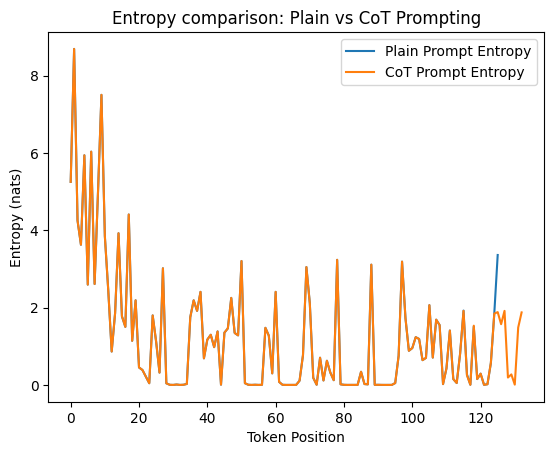

In [27]:
# Step 7: Optionally visualize or print a few values
import matplotlib.pyplot as plt
# Convert from bfloat16 to float32
entropy_plain_np = entropy_plain[0].cpu().numpy().astype(np.float32)
entropy_cot_np   = entropy_cot[0].cpu().numpy().astype(np.float32)
print(entropy_plain_np.shape)
print(entropy_cot_np.shape)

plt.plot(entropy_plain_np, label="Plain Prompt Entropy")
plt.plot(entropy_cot_np, label="CoT Prompt Entropy")
plt.xlabel("Token Position")
plt.ylabel("Entropy (nats)")
plt.legend()
plt.title("Entropy comparison: Plain vs CoT Prompting")
plt.show()

https://huggingface.co/docs/transformers/v4.51.3/en/main_classes/text_generation#transformers.GenerationMixin.generate